In [1]:
# Install dependencies
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
import numpy as np

In [3]:
# Import data
data = pd.read_csv("bank_transactions_data_2.csv")

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [4]:
# Check for missing values: No missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


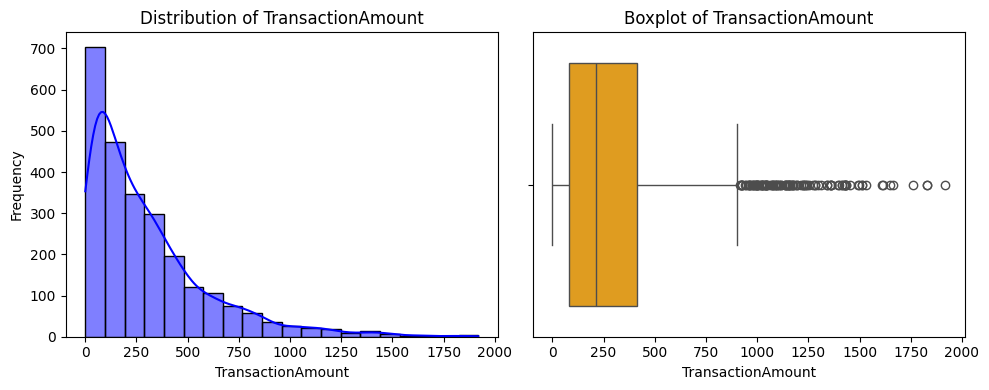

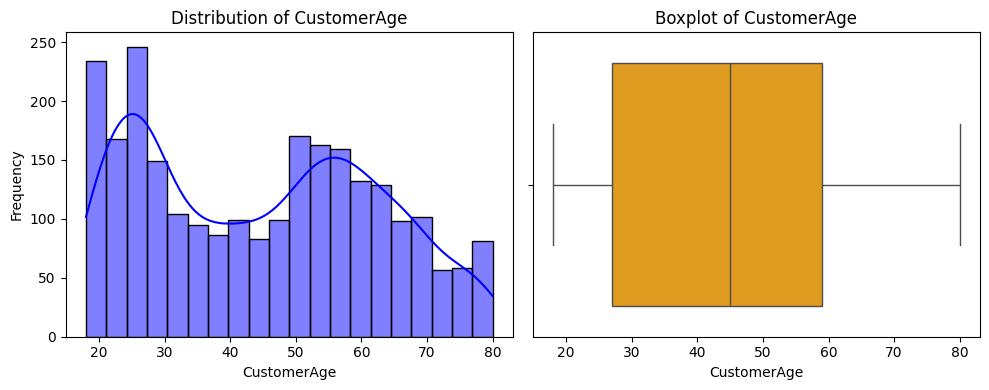

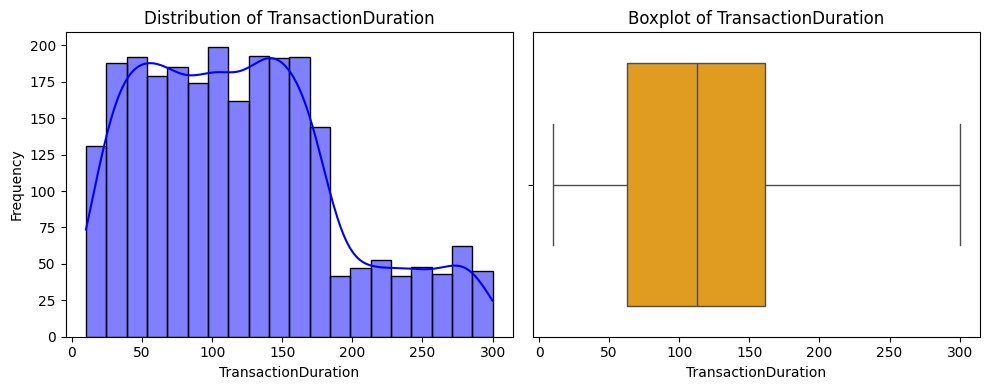

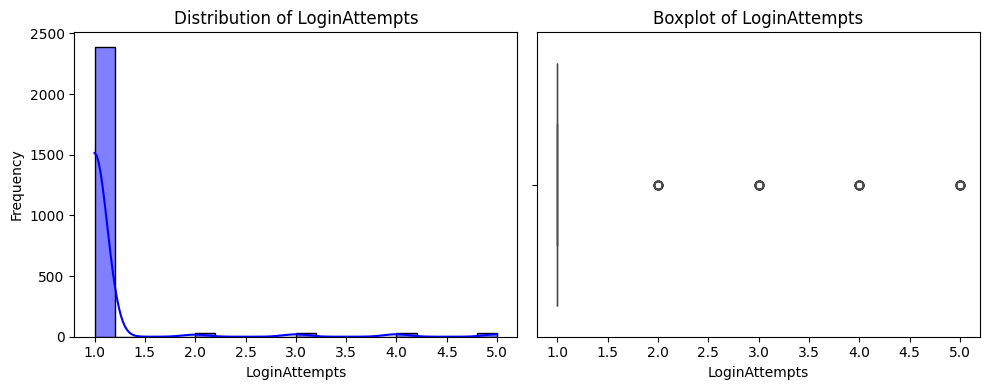

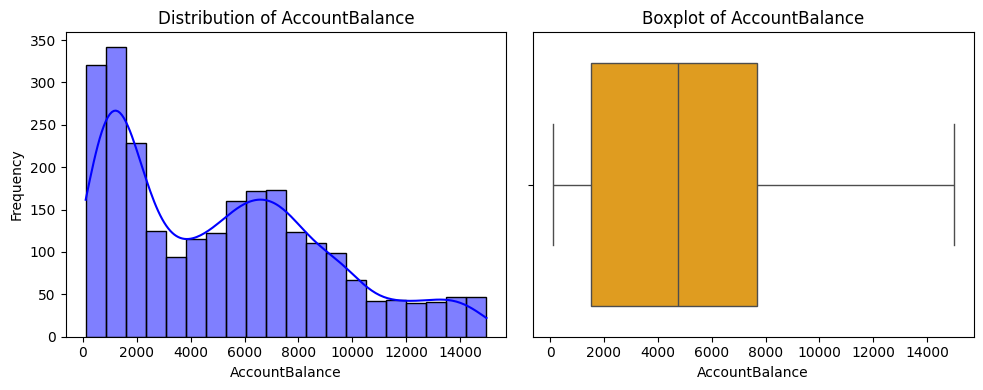

In [5]:
# Data visualisation (univariate analysis) - Numeric columns

# Identify numeric and categorical columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Plot univariate graphs
# For numeric columns: Histograms and Boxplots
for col in numeric_cols:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=20, color='blue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

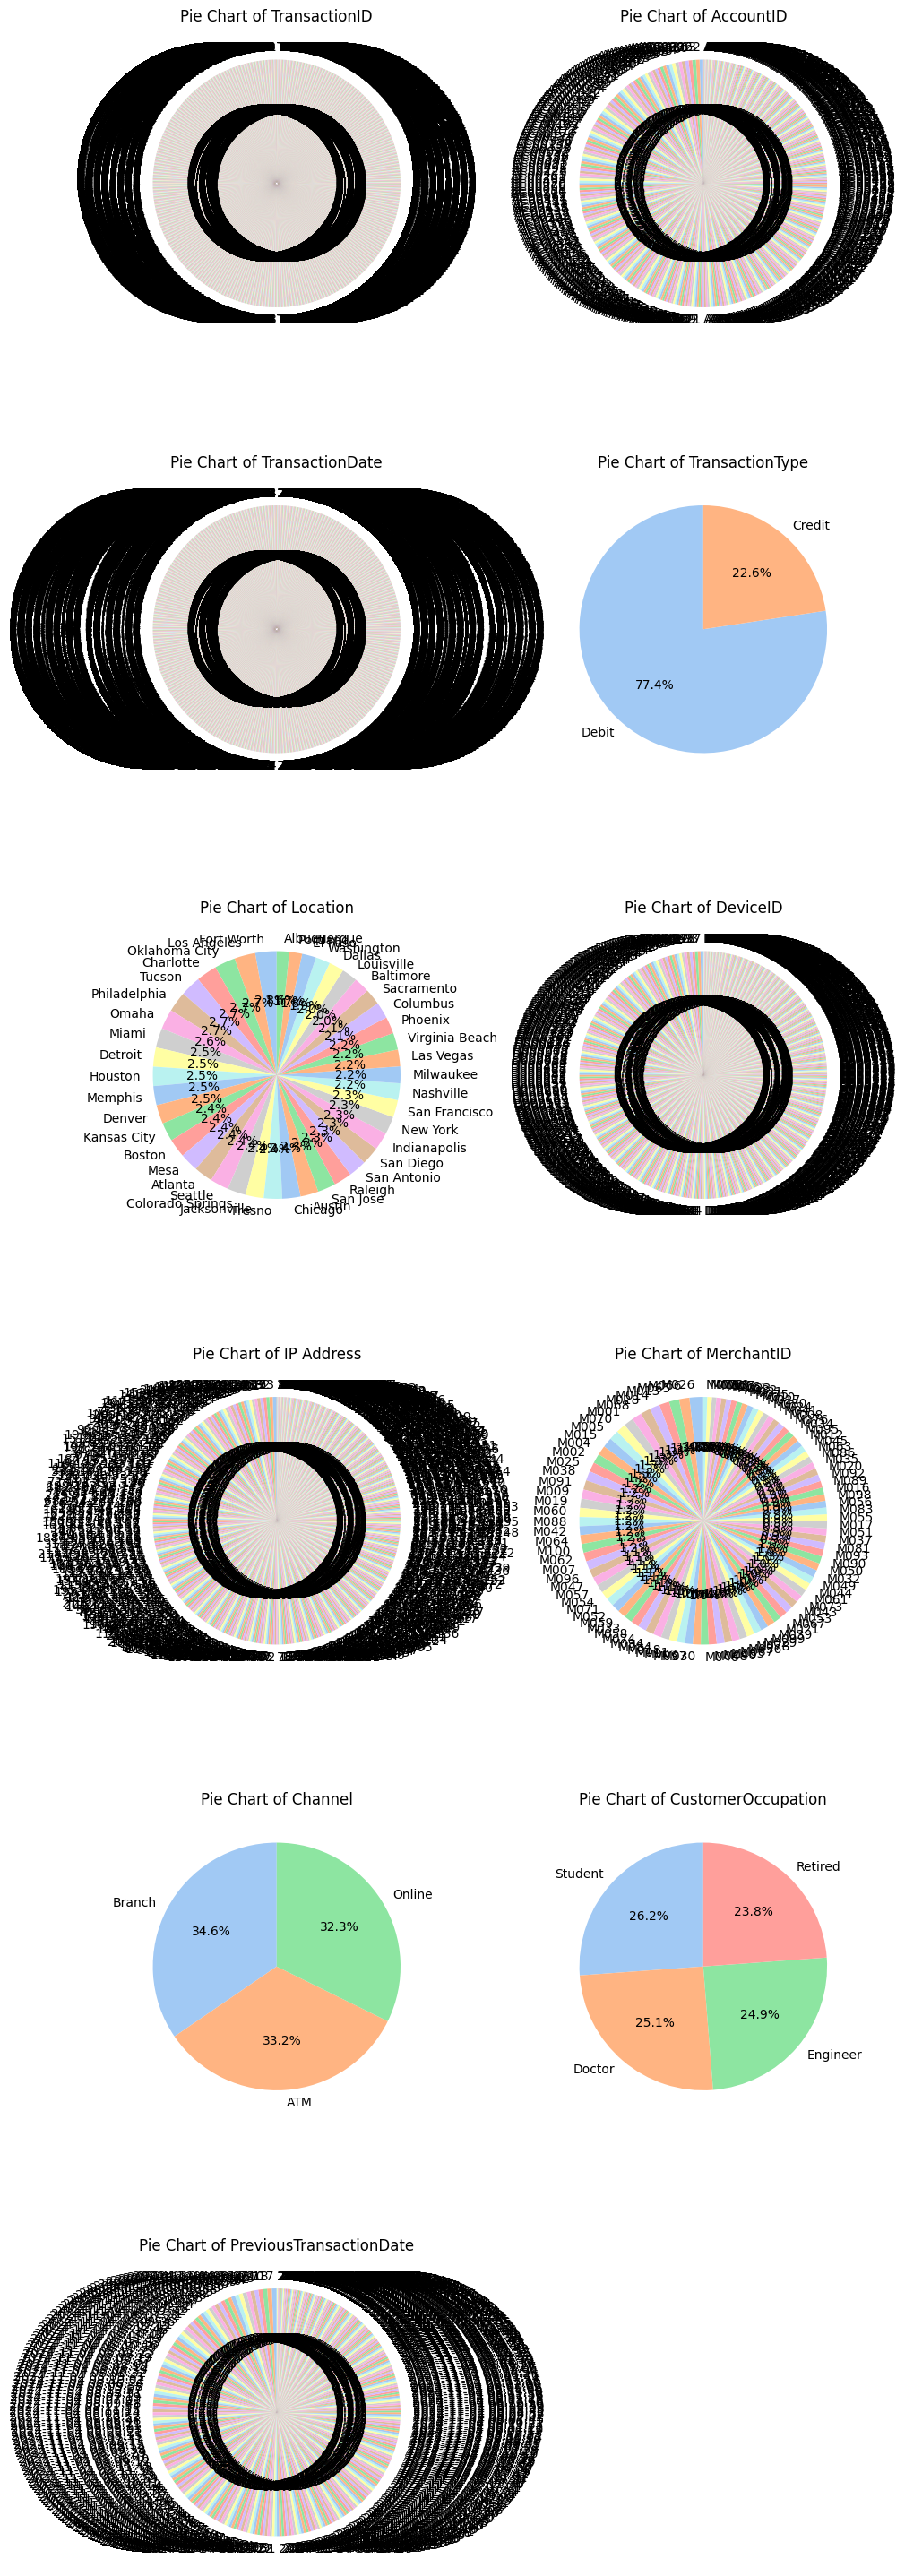

In [6]:
# Data visualisation (univariate analysis) - Categorical columns

# Define the number of columns you want per row
num_cols = 2  # Adjust this based on your preference
num_rows = -(-len(categorical_cols) // num_cols)  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

# Flatten axes array if there's more than one row
axes = axes.flatten() if num_rows > 1 else [axes]

for i, col in enumerate(categorical_cols):
    data[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel')
    )
    axes[i].set_title(f'Pie Chart of {col}', fontsize=12)
    axes[i].set_ylabel('')  # Remove default y-axis label

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



Correlation Matrix:
                     TransactionAmount  CustomerAge  TransactionDuration  \
TransactionAmount             1.000000    -0.025616             0.004359   
CustomerAge                  -0.025616     1.000000            -0.017936   
TransactionDuration           0.004359    -0.017936             1.000000   
LoginAttempts                -0.008445     0.007653             0.032639   
AccountBalance               -0.025165     0.319942             0.005577   

                     LoginAttempts  AccountBalance  
TransactionAmount        -0.008445       -0.025165  
CustomerAge               0.007653        0.319942  
TransactionDuration       0.032639        0.005577  
LoginAttempts             1.000000        0.014999  
AccountBalance            0.014999        1.000000  


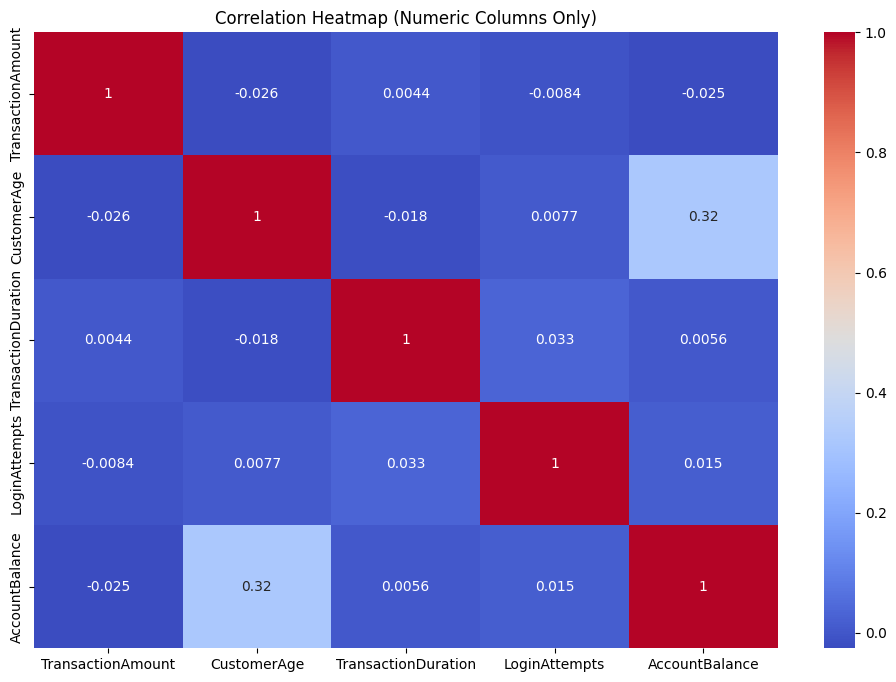

In [7]:
# Data visualisation (HEATMAP)
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for numeric data only
correlation_matrix = numeric_data.corr()

# Verify the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Columns Only)')
plt.show()



In [8]:
# Data Preprocessing
original_data = data.copy()

# Handle categorical data
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'])

# Drop columns that are not needed for the model
data = data.drop(columns=['TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'MerchantID'])

# Preprocessing: Handle datetime columns
data['TimeSinceLastTransaction'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds()

# Identify numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'CustomerAge', 'TimeSinceLastTransaction']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

# Normalize numeric columns
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Descriptive Statistics
print("Descriptive Statistics:")
print(data.describe())

# Initialize Fraud column
data['Fraud'] = False

print("Processed Data:")
print(data.head())
print(data.info())

Descriptive Statistics:


       TransactionAmount                TransactionDate  TransactionType  \
count       2.512000e+03                           2512      2512.000000   
mean       -1.414297e-16  2023-07-05 20:32:10.826433024         0.773885   
min        -1.018657e+00            2023-01-02 16:00:06         0.000000   
25%        -7.390118e-01  2023-04-03 16:22:05.750000128         1.000000   
50%        -2.961881e-01     2023-07-07 17:49:43.500000         1.000000   
75%         4.006114e-01     2023-10-06 18:40:53.500000         1.000000   
max         5.555266e+00            2024-01-01 18:21:50         1.000000   
std         1.000199e+00                            NaN         0.418398   

          Location      Channel   CustomerAge  CustomerOccupation  \
count  2512.000000  2512.000000  2.512000e+03         2512.000000   
mean     21.032643     0.991242  9.900078e-18            1.510350   
min       0.000000     0.000000 -1.499493e+00            0.000000   
25%      11.000000     0.000000 -9.935

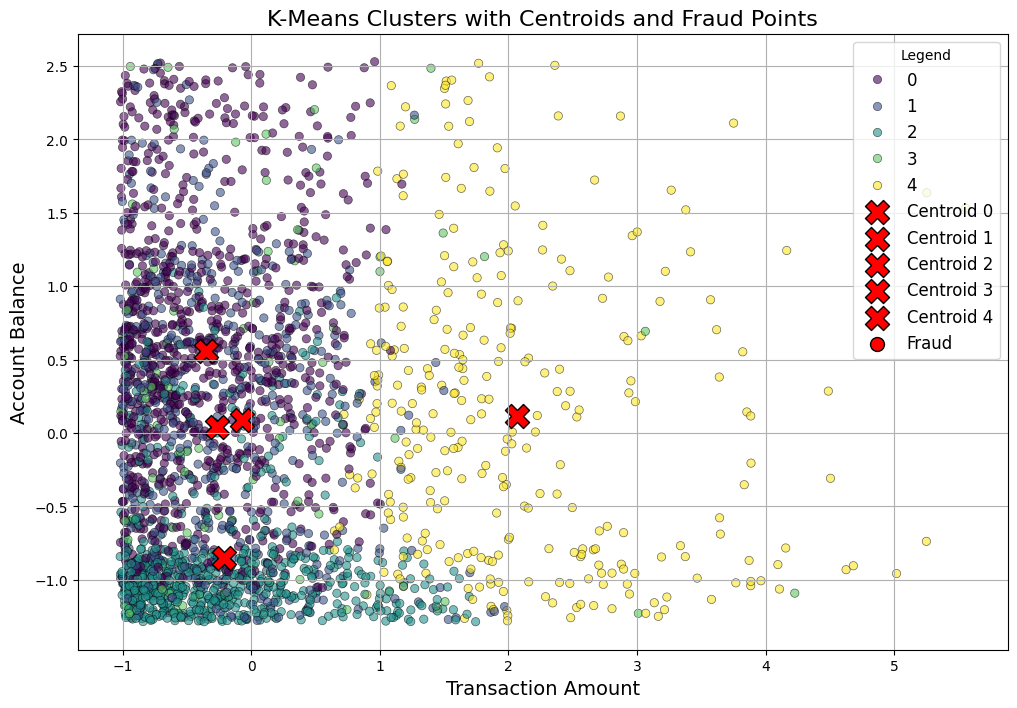

Total Fraudulent Transactions Detected (Using K Means clustering): 70


In [9]:
# Standardize numeric columns before clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_cols])

# Perform K-Means clustering
n_clusters = 5  # Adjust number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(data_scaled)
data['KMeans_Cluster'] = kmeans_labels

# Calculate centroids and inverse-transform them
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Calculate distances from centroids
distances = np.linalg.norm(data_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)
data['KMeans_Distance'] = distances

# Set fraud detection threshold: Mean + 2 * Standard Deviation (Adjust as needed)
threshold = distances.mean() + 2 * distances.std()
data['KMeans_Fraud'] = distances > threshold  # Use only one fraud flag

# Scatterplot for two features with clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['KMeans_Cluster'],
    palette='viridis',
    alpha=0.6,  # Reduce opacity
    edgecolor='black'
)

# Overlay centroids
for i, centroid in enumerate(centroids_original):
    plt.scatter(
        centroid[numeric_cols.index('TransactionAmount')],
        centroid[numeric_cols.index('AccountBalance')],
        color='red',
        marker='X',
        s=300,  # Increase size
        edgecolors='black',
        label=f'Centroid {i}'
    )

# Highlight fraud points
fraud_points = data[data['Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['AccountBalance'],
    color='red',
    marker='o',
    s=100,  # Increase fraud point size
    edgecolors='black',
    label='Fraud'
)

plt.title('K-Means Clusters with Centroids and Fraud Points', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Legend', fontsize=12)
plt.grid(True)
plt.show()

# Print fraud summary
total_kmeans_fraud_points = data['KMeans_Fraud'].sum()
data['Fraud'] |= data['KMeans_Fraud']
print(f"Total Fraudulent Transactions Detected (Using K Means clustering): {total_kmeans_fraud_points}")


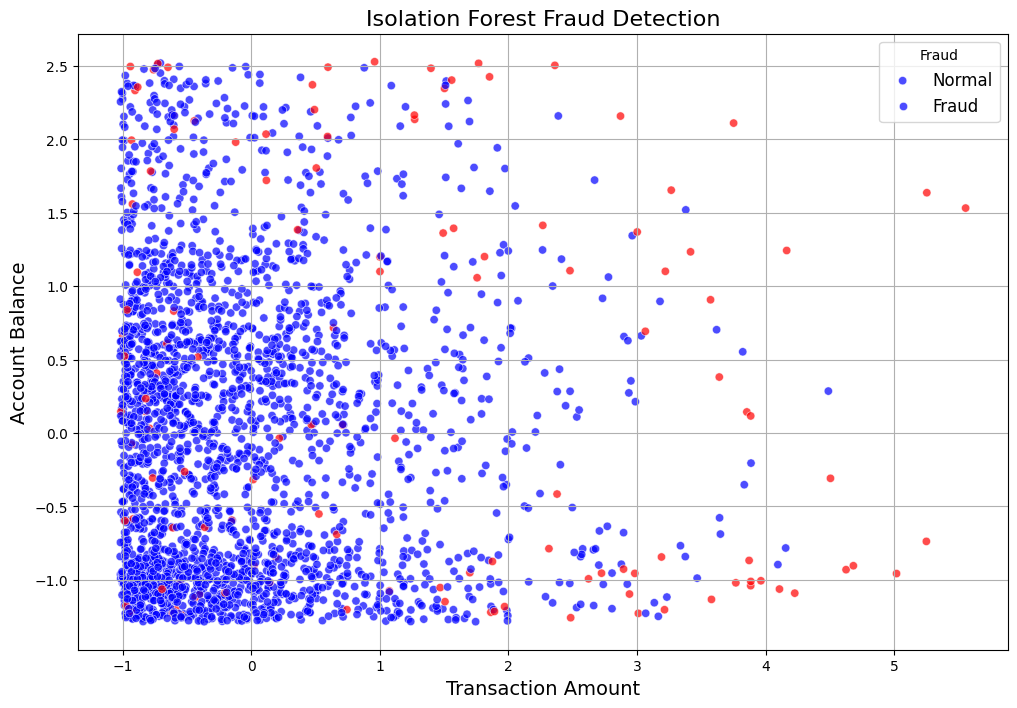

Total Fraudulent Transactions Detected (using isolation forest): 126


In [10]:
# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
features = data.drop(columns=['Fraud', 'TransactionDate', 'PreviousTransactionDate']).columns
data["IsoForest_Fraud"] = iso_forest.fit_predict(data[features])
data["IsoForest_Fraud"] = data["IsoForest_Fraud"].map({1: 0, -1: 1})

# Scatterplot to visualize fraud points
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['IsoForest_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('Isolation Forest Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

total_iso_fraud_points = data['IsoForest_Fraud'].sum()
data['Fraud'] |= data['IsoForest_Fraud']
print(f"Total Fraudulent Transactions Detected (using isolation forest): {total_iso_fraud_points}")


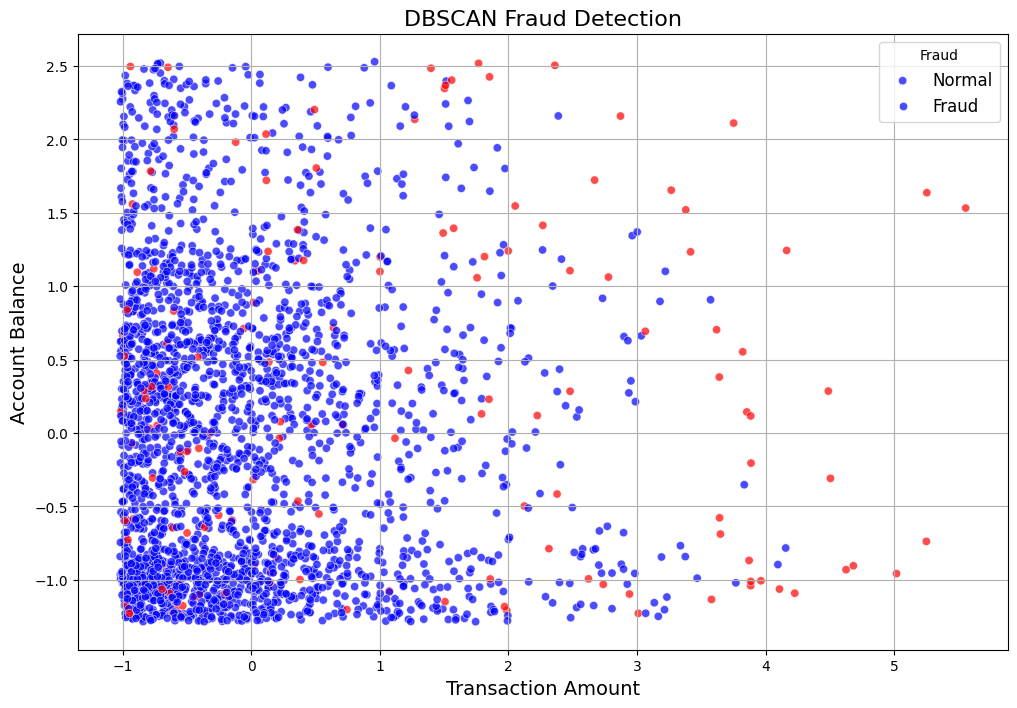

Total Fraudulent Transactions Detected by DBSCAN: 153


In [11]:
#DBSCAN Analysis

features = data.drop(columns=['Fraud', 'TransactionDate', 'PreviousTransactionDate']).columns
dbscan = DBSCAN(eps=3, min_samples=8)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(data[features])
data['DBSCAN_Cluster'] = dbscan_labels
data['DBSCAN_Fraud'] = data['DBSCAN_Cluster'] == -1

# Scatterplot for DBSCAN fraud detection
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['DBSCAN_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('DBSCAN Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

total_dbscan_fraud_points = data['DBSCAN_Fraud'].sum()
data['Fraud'] |= data['DBSCAN_Fraud']
print(f"Total Fraudulent Transactions Detected by DBSCAN: {total_dbscan_fraud_points}")

In [12]:
total_fraud_points = data['Fraud'].sum()
print(f"Total Fraudulent Transactions Detected: {total_fraud_points}")

original_data['Fraud'] = data['Fraud']
original_data.to_csv("original_data_with_fraud.csv", index=False)
print("Original data with Fraud column saved as 'original_data_with_fraud.csv'")

Total Fraudulent Transactions Detected: 181
Original data with Fraud column saved as 'original_data_with_fraud.csv'


Training Data

In [17]:
# Import models and utility functions
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
# Data splitting and preprocessing for new data
# Import new data
data = pd.read_csv("original_data_with_fraud.csv")

# Drop unnecessary columns
data = data.drop(columns=['TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'MerchantID'])

# Convert datetime columns & create a new feature
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'])
data['TimeSinceLastTransaction'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds()

# Identify numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'CustomerAge', 'TimeSinceLastTransaction']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation']

# 1. Split Before Preprocessing (Prevents Data Leakage)
X = data.drop(columns=['Fraud', 'TransactionDate', 'PreviousTransactionDate'])  # Features
y = data['Fraud']  # Target variable

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Preprocess Training Data
scaler = StandardScaler()
train_X[numeric_cols] = scaler.fit_transform(train_X[numeric_cols])  # Learn & apply scaling
label_encoder = LabelEncoder()

# Fit LabelEncoder on the entire dataset (both train and test sets) to avoid unseen labels
for col in categorical_cols:
    # Fit encoder on the entire data (training and test)
    label_encoder.fit(data[col])
    train_X[col] = label_encoder.transform(train_X[col])  # Learn & apply encoding on training set
    test_X[col] = label_encoder.transform(test_X[col])  # Apply encoding (NO fit) on test set

# 3. Apply Preprocessing to Test Data (Using Training Parameters)
test_X[numeric_cols] = scaler.transform(test_X[numeric_cols])  # Apply scaling (NO fit)

In [22]:
# Gradient Boosting Classification

# 4. Proceed with Gradient Boosting (GB)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'max_features': [5, 'sqrt', 'log2'],
    'subsample': [0.8, 1.0],  # Fraction of samples to use for fitting each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split an internal node
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_X, train_y)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train model using best parameters
gbc = GradientBoostingClassifier(**best_params, random_state=42)
gbc.fit(train_X, train_y)

# Evaluate model on test set
pred_y = gbc.predict(test_X)
acc = accuracy_score(test_y, pred_y)

print(f"\nGradient Boosting Classifier Accuracy: {acc}")
print("\nClassification Report:\n", classification_report(test_y, pred_y))
print("\nConfusion Matrix:\n", confusion_matrix(test_y, pred_y))

# Feature Importance (Optional)
importances = gbc.feature_importances_
print("\nFeature Importances:")
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")

c:\Users\phang\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0}

Gradient Boosting Classifier Accuracy: 0.974155069582505

Classification Report:
               precision    recall  f1-score   support

       False       0.98      1.00      0.99       466
        True       0.93      0.70      0.80        37

    accuracy                           0.97       503
   macro avg       0.95      0.85      0.89       503
weighted avg       0.97      0.97      0.97       503


Confusion Matrix:
 [[464   2]
 [ 11  26]]

Feature Importances:
TransactionAmount: 0.22946101583559558
TransactionType: 0.0023832163788296383
Location: 0.008376693510572202
Channel: 0.001151808888421361
CustomerAge: 0.017890573937478678
CustomerOccupation: 0.0061000183359919075
TransactionDuration: 0.03856528498483263
LoginAttempts: 0.5878180102929188
AccountBalance: 0.07653534269325678
TimeSinceLastTransaction: 0.03171803514210258
